In [65]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
#Optimization
import optuna

In [66]:
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)


In [67]:
print(raw_train_data.shape)
raw_train_data.head()

(2190, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


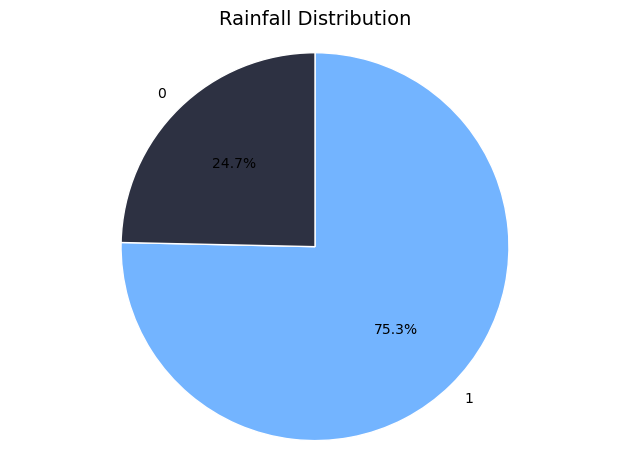

In [68]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [69]:
raw_train_data.skew()

day              0.030615
pressure         0.284062
maxtemp         -0.490890
temparature     -0.557471
mintemp         -0.649179
dewpoint        -0.997889
humidity        -0.561541
cloud           -1.339274
sunshine         0.639871
winddirection    0.708063
windspeed        0.769390
rainfall        -1.176743
dtype: float64

In [86]:
imputer = SimpleImputer(strategy= 'median')

def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['cloud'] = np.log1p(df['cloud'])
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns= df.columns)

    return df

def test_data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['cloud'] = np.log1p(df['cloud'])
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    df_imputed = imputer.transform(df)
    df = pd.DataFrame(df_imputed, columns= df.columns)

    return df

In [87]:
X_train = raw_train_data.drop(columns= 'rainfall')
y_train = raw_train_data['rainfall']
X_train = data_preproccesing(X_train) 

In [88]:
X_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,temp_change,temp_ratio,wind_dir_rad,wind_direction_sin,wind_direction_cos,avg_temp,dewpoint_depression,sunshine_ratio
0,1.0,1017.4,21.2,20.6,19.9,19.4,87.0,4.488636,1.1,17.2,1.3,1.065327,1.047198,0.866025,0.500000,20.55,1.2,0.200414
1,2.0,1019.5,16.2,16.9,15.8,15.4,95.0,4.521789,0.0,21.9,0.4,1.025316,0.872665,0.766044,0.642788,16.00,1.5,0.000000
2,3.0,1024.1,19.4,16.1,14.6,9.3,75.0,3.871201,8.3,18.1,4.8,1.328767,1.221730,0.939693,0.342020,17.00,6.8,1.703892
3,4.0,1013.4,18.1,17.8,16.9,16.8,95.0,4.564348,0.0,35.6,1.2,1.071006,1.047198,0.866025,0.500000,17.50,1.0,0.000000
4,5.0,1021.8,21.3,18.4,15.2,9.6,52.0,3.828641,3.6,24.8,6.1,1.401316,0.698132,0.642788,0.766044,18.25,8.8,0.745551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361.0,1014.6,23.2,20.6,19.1,19.9,97.0,4.488636,0.1,22.1,4.1,1.214660,0.698132,0.642788,0.766044,21.15,0.7,0.018219
2186,362.0,1012.4,17.2,17.3,16.3,15.3,91.0,4.488636,0.0,35.3,0.9,1.055215,0.872665,0.766044,0.642788,16.75,2.0,0.000000
2187,363.0,1013.3,19.0,16.3,14.3,12.6,79.0,4.382027,5.0,32.9,4.7,1.328671,0.698132,0.642788,0.766044,16.65,3.7,0.929018
2188,364.0,1022.3,16.4,15.2,13.8,14.7,92.0,4.543295,0.1,18.0,2.6,1.188406,0.698132,0.642788,0.766044,15.10,0.5,0.018040


In [89]:
def objective(trial, X, y):
    # Define hyperparameters in a dictionary (best practice)
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 8, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 10),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.001, 0.5),
        'random_state': 42
    }
    
    clf = DecisionTreeClassifier(**params)
    
    # 5-split StratifiedKFold to maintain class balance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        clf.fit(X_train, y_train)
        # Use predicted probabilities for ROC AUC calculation
        train_proba = clf.predict_proba(X_train)[:, 1]
        val_proba = clf.predict_proba(X_test)[:, 1]
        train_scores.append(roc_auc_score(y_train, train_proba))
        val_scores.append(roc_auc_score(y_test, val_proba))
    
    avg_train_auc = np.mean(train_scores)
    avg_val_auc = np.mean(val_scores)
    
    # Print out trial metrics immediately after evaluation
    print(f"Trial {trial.number} - Train AUC: {avg_train_auc:.4f} | Validation AUC: {avg_val_auc:.4f}")
    
    return avg_val_auc

In [90]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-06 16:55:00,569] A new study created in memory with name: no-name-180b60b5-ac3c-4ba5-aa84-4ad5cdad8cff
[I 2025-03-06 16:55:00,602] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.2403950683025824, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.48498501622883516}. Best is trial 0 with value: 0.5.
[I 2025-03-06 16:55:00,621] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.5722807884690141, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.18381455980355216}. Best is trial 0 with value: 0.5.
[I 2025-03-06 16:55:00,637] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 0.1418053

Trial 0 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 1 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 2 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 3 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 4 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 5 - Train AUC: 0.7312 | Validation AUC: 0.7270
Trial 6 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 7 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 8 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 9 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 10 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 11 - Train AUC: 0.8781 | Validation AUC: 0.8570


[I 2025-03-06 16:55:00,816] Trial 12 finished with value: 0.859702581369248 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 0.3557986648977259, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0025504925578717207}. Best is trial 12 with value: 0.859702581369248.
[I 2025-03-06 16:55:00,839] Trial 13 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.3519918777432741, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.08060591825511665}. Best is trial 12 with value: 0.859702581369248.
[I 2025-03-06 16:55:00,861] Trial 14 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.3639258445358244, 'splitter': 'best', 'cl

Trial 12 - Train AUC: 0.8827 | Validation AUC: 0.8597
Trial 13 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 14 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 15 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 16 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 17 - Train AUC: 0.8452 | Validation AUC: 0.8369
Trial 18 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 19 - Train AUC: 0.6311 | Validation AUC: 0.6144
Trial 20 - Train AUC: 0.8197 | Validation AUC: 0.8180


[I 2025-03-06 16:55:01,031] Trial 21 finished with value: 0.8615123456790122 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 0.721401644906162, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.005387338982238948}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,057] Trial 22 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 0.7187930782228931, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.05692421268153939}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,083] Trial 23 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.8113334768584826, 'splitter': 'best', 'c

Trial 21 - Train AUC: 0.8699 | Validation AUC: 0.8615
Trial 22 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 23 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 24 - Train AUC: 0.8610 | Validation AUC: 0.8486
Trial 25 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 26 - Train AUC: 0.8156 | Validation AUC: 0.8071
Trial 27 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 28 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 29 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-06 16:55:01,241] Trial 30 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 0.1049617814601671, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.42277692954979296}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,278] Trial 31 finished with value: 0.8524214365881033 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 0.9805638867757158, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.0026787731174011988}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,313] Trial 32 finished with value: 0.8512177328843995 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 0.8384120438818744, 'splitter': 'best', 'class_weight': '

Trial 30 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 31 - Train AUC: 0.8864 | Validation AUC: 0.8524
Trial 32 - Train AUC: 0.8781 | Validation AUC: 0.8512
Trial 33 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 34 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 35 - Train AUC: 0.8773 | Validation AUC: 0.8542
Trial 36 - Train AUC: 0.7087 | Validation AUC: 0.6930


[I 2025-03-06 16:55:01,447] Trial 37 finished with value: 0.8179629629629629 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 0.739928610691465, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.17806422966087454}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,469] Trial 38 finished with value: 0.7633361391694726 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.9157945686520628, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.03586396126274381}. Best is trial 21 with value: 0.8615123456790122.
[I 2025-03-06 16:55:01,492] Trial 39 finished with value: 0.666060606060606 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.5539597282027816, 'splitter': 'best', '

Trial 37 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 38 - Train AUC: 0.7625 | Validation AUC: 0.7633
Trial 39 - Train AUC: 0.6842 | Validation AUC: 0.6661
Trial 40 - Train AUC: 0.7312 | Validation AUC: 0.7270
Trial 41 - Train AUC: 0.8847 | Validation AUC: 0.8639
Trial 42 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 43 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 44 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 45 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-06 16:55:01,676] Trial 46 finished with value: 0.8533249158249159 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 0.5812941729834543, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0014701403164262743}. Best is trial 41 with value: 0.8638720538720539.
[I 2025-03-06 16:55:01,696] Trial 47 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 0.6799606035915606, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.4512706090699645}. Best is trial 41 with value: 0.8638720538720539.
[I 2025-03-06 16:55:01,719] Trial 48 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 0.4076467911430714, 'splitter': 'best', 'class_weight':

Trial 46 - Train AUC: 0.8758 | Validation AUC: 0.8533
Trial 47 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 48 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 49 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 50 - Train AUC: 0.8156 | Validation AUC: 0.8071
Trial 51 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 52 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 53 - Train AUC: 0.8839 | Validation AUC: 0.8653
Trial 54 - Train AUC: 0.8197 | Validation AUC: 0.8180


[I 2025-03-06 16:55:01,876] Trial 54 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 0.7092835183213109, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.026609249386544773}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:01,900] Trial 55 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 0.38595747083805154, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.06708230715522853}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:01,926] Trial 56 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 0.7554707124877116, 'splitter': 'best', 

Trial 55 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 56 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 57 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 58 - Train AUC: 0.8105 | Validation AUC: 0.8102
Trial 59 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 60 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 61 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 62 - Train AUC: 0.8273 | Validation AUC: 0.8240
Trial 63 - Train AUC: 0.8752 | Validation AUC: 0.8574


[I 2025-03-06 16:55:02,122] Trial 64 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.6133983402842954, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.03683358785049401}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,147] Trial 65 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.647748140801541, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.05376163161272059}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,181] Trial 66 finished with value: 0.8542143658810325 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 0.8010347675985188, 'splitter': 'best', 'clas

Trial 64 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 65 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 66 - Train AUC: 0.8773 | Validation AUC: 0.8542
Trial 67 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 68 - Train AUC: 0.8042 | Validation AUC: 0.7973
Trial 69 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 70 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 71 - Train AUC: 0.8802 | Validation AUC: 0.8625


[I 2025-03-06 16:55:02,338] Trial 72 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 0.819386793054278, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0359125510173187}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,365] Trial 73 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 0.7759437117917874, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.016571332173920462}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,397] Trial 74 finished with value: 0.864436026936027 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 0.6684965708455155, 'splitter': 'best', 'clas

Trial 72 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 73 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 74 - Train AUC: 0.8784 | Validation AUC: 0.8644
Trial 75 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 76 - Train AUC: 0.7312 | Validation AUC: 0.7270
Trial 77 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 78 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 79 - Train AUC: 0.8042 | Validation AUC: 0.7973


[I 2025-03-06 16:55:02,565] Trial 80 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 0.6919215864196278, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.028497159296152784}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,595] Trial 81 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.7622647837125155, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.011810114304026245}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,625] Trial 82 finished with value: 0.8549046015712681 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.4422482713309171, 'splitter': 'best', 'c

Trial 80 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 81 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 82 - Train AUC: 0.8735 | Validation AUC: 0.8549
Trial 83 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 84 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 85 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 86 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 87 - Train AUC: 0.8761 | Validation AUC: 0.8522


[I 2025-03-06 16:55:02,775] Trial 88 finished with value: 0.726969696969697 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 12, 'max_features': 0.4274897819668977, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.07593695527668474}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,801] Trial 89 finished with value: 0.8179629629629629 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_features': 0.5338860765887402, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.04091223395568198}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:02,825] Trial 90 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 0.7248582884380942, 'splitter': 'best', 'class_weight'

Trial 88 - Train AUC: 0.7312 | Validation AUC: 0.7270
Trial 89 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 90 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 91 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 92 - Train AUC: 0.8793 | Validation AUC: 0.8610
Trial 93 - Train AUC: 0.8847 | Validation AUC: 0.8639
Trial 94 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 95 - Train AUC: 0.8197 | Validation AUC: 0.8180


[I 2025-03-06 16:55:02,991] Trial 96 finished with value: 0.8179629629629629 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6407387409570532, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0462279987825049}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:03,016] Trial 97 finished with value: 0.8099354657687992 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 0.5688644482197468, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.013346020185863224}. Best is trial 53 with value: 0.8653198653198654.
[I 2025-03-06 16:55:03,040] Trial 98 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.6879580143404794, 'splitter': 'best', 'class_weight': 'balance

Trial 96 - Train AUC: 0.8197 | Validation AUC: 0.8180
Trial 97 - Train AUC: 0.8221 | Validation AUC: 0.8099
Trial 98 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 99 - Train AUC: 0.8197 | Validation AUC: 0.8180


In [91]:
best_params = {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 0.7038558626681246, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0022046111063950173}
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features=0.9218626242336535,
                       max_leaf_nodes=30,
                       min_impurity_decrease=0.011034408259325605,
                       min_samples_leaf=13, min_samples_split=19)

In [92]:
X_test = test_data_preproccesing(raw_test_data)

In [96]:
predictions = best_model.predict_proba(X_test)[:, 1]

In [97]:
sample_submission['rainfall'] = predictions

In [98]:
sample_submission.to_csv('submission.csv', index= False)